In [61]:
import numpy as np
import matplotlib.pylab as plt
import math as math
from scipy.optimize import fmin
from iminuit import Minuit, describe, Struct

%matplotlib  notebook

In [62]:
# Add code to the following function so that it takes in two datasets, loops over one of them, and finds
# information about the nearest neighbors in the other dataset, based on a flag. 

def nn(data0,data1,r=None,nneighbors=None):
    
    ret = -1
    ret_list=[]
    if r is not None and nneighbors is not None:
        exit(-1)
        return ret
    elif r is not None and nneighbors is None:
        for num0 in data0:
            count=0
            diff = np.abs(num0 - data1)
            count = len(diff[diff<r])
            ret_list.append(float(count)/(float(len(data1))*r))
        ret_list = np.array(ret_list)
        return ret_list
    elif r is None and nneighbors is not None:
        for num0 in data0:
            diff = np.abs(num0 - data1)
            diff.sort()
            radius= diff[nneighbors-1]
            ret_list.append(1/radius)
        ret_list = np.array(ret_list)
        return ret_list
    return ret

In [77]:
def normal(x,mean,width):
    return (1.0/(width*np.sqrt(2*np.pi)))*(np.exp(-(x-mean)**2/(2*(width**2))))

def calc_pull(iterations, dataPoints, MC, rad):
    pull_frac_list=[]
    average_best_frac = 0
    frac = []
    fit_frac = []
    fit_frac_uncert = []
    
    

    for num in range(iterations):
        Nsig = np.random.poisson(dataPoints)
        sig_mean=10.4
        sig_width=.06
        signal = np.random.normal(sig_mean,sig_width,Nsig)
        Nbkg = 1000
        background = 9.0+(2*np.random.random(Nbkg))
        data = signal.copy()
        data = np.append(data,background.copy())

        frac.append(float(Nsig)/(float(Nbkg)+float(Nsig)))
        Nsig_compare = MC
        sig_mean_compare=10.4
        sig_width_compare = .06
        signal_compare = np.random.normal(sig_mean_compare,sig_width_compare,Nsig_compare)
        
        Nbkg_compare= MC
        background_compare= 9.0+(2*np.random.random(Nbkg_compare))
        
        def probability(frac):
            tot_prob=[]
            #signal_prob=nn(data,signal_compare, nneighbors=100)
            #background_prob= nn(data, background_compare, nneighbors=100)
            signal_prob=nn(data,signal_compare, r=rad)
            background_prob= nn(data, background_compare, r=rad)
            tot_prob.append(frac*signal_prob+ ((1-frac)*background_prob))
            tot_prob=np.array(tot_prob)
            return -np.log(tot_prob[tot_prob>0]).sum()
        
        m=Minuit(probability, frac= .50, limit_frac=(0.001,1), error_frac=0.001,  errordef = 0.5, print_level=0)
        m.migrad()
        if (m.get_fmin().is_valid):
            param=m.values
            err=m.errors
            fit_frac.append(param["frac"])
            fit_frac_uncert.append(err["frac"])
            pull_frac=((float(Nsig)/(float(Nbkg)+float(Nsig)))-param["frac"])/err["frac"]
            pull_frac_list.append(pull_frac)
    return pull_frac_list, frac, fit_frac, fit_frac_uncert,iterations

In [ ]:
means=[]
stds=[]

for sig in [50,150,300]:
    for MC in [1000,5000,10000]:
        for rad in [0.01,0.05]: #, 0.10,0.20,0.50]:
            
            print 'number of signal points: %s \t number of MC point: %s \tradius: %s' % (sig,MC,rad)
            pulls,org_vals,fit_vals,fit_uncerts,iteration = calc_pull(10, sig, MC, rad)
            #plt.figure()
            #plt.hist(pulls, bins=50)
            #x = np.linspace(-5,5,1000)
            #y=normal(x,0,1)
            #plt.plot(x,(iteration*7/(50))*y,'y-',linewidth=2)
            parameters_mean = {'signal': sig, 'MC_points': MC, 'radius': rad, 'mean pulls': np.mean(pulls)}
            means.append(parameters_mean)
            parameters_std = {'signal': sig, 'MC_points': MC, 'radius': rad, 'mean stds': np.std(pulls)}
            stds.append(parameters_std)
            

plt.figure(figsize=(12,12))
point_color='bo'
sizes=0

for item in means:
    if (item['signal']==50):
        sizes=3
        if (item['MC_points']==1000):
            point_color='ro'
        if (item['MC_points']==5000):
            point_color='bo'
        if (item['MC_points']==10000):
            point_color='go'
    if (item['signal']==150):
        sizes=10
        if (item['MC_points']==1000):
            point_color='ro'
        if (item['MC_points']==5000):
            point_color='bo'
        if (item['MC_points']==10000):
            point_color='go'
    if (item['signal']==300):
        sizes=17
        if (item['MC_points']==1000):
            point_color='ro'
        if (item['MC_points']==5000):
            point_color='bo'
        if (item['MC_points']==10000):
            point_color='go'
    plt.plot(item['radius'],item['mean pulls'], point_color, markersize=sizes)#, label=('signal points %s \t num of MC points %s \t'% (item['signal'], item['MC_points']) ))
    plt.xlim(-.1,0.6)
    


plt.legend()
plt.figure(figsize=(12,12))
point_color='bo'

for item in stds:
    if (item['signal']==50):
        sizes=5
        if (item['MC_points']==1000):
            point_color='ro'
        if (item['MC_points']==5000):
            point_color='bo'
        if (item['MC_points']==10000):
            point_color='go'
    if (item['signal']==150):
        sizes=10
        if (item['MC_points']==1000):
            point_color='ro'
        if (item['MC_points']==5000):
            point_color='bo'
        if (item['MC_points']==10000):
            point_color='go'
    if (item['signal']==300):
        sizes=15
        if (item['MC_points']==1000):
            point_color='ro'
        if (item['MC_points']==5000):
            point_color='bo'
        if (item['MC_points']==10000):
            point_color='go'
    plt.plot(item['radius'],item['mean stds'], point_color, markersize=sizes)#, label=('signal points %s \t num of MC points %s \t'% (item['signal'], item['MC_points']) ))
    plt.xlim(-.1,0.6)

plt.legend()



#WITH THE POISSON and 100 iterations- TESTING IT

number of signal points: 50 	 number of MC point: 1000 	radius: 0.01
number of signal points: 50 	 number of MC point: 1000 	radius: 0.05
number of signal points: 50 	 number of MC point: 1000 	radius: 0.1
number of signal points: 50 	 number of MC point: 5000 	radius: 0.01
number of signal points: 50 	 number of MC point: 5000 	radius: 0.05
number of signal points: 50 	 number of MC point: 5000 	radius: 0.1
number of signal points: 50 	 number of MC point: 10000 	radius: 0.01
number of signal points: 50 	 number of MC point: 10000 	radius: 0.05
number of signal points: 50 	 number of MC point: 10000 	radius: 0.1
number of signal points: 150 	 number of MC point: 1000 	radius: 0.01
number of signal points: 150 	 number of MC point: 1000 	radius: 0.05
number of signal points: 150 	 number of MC point: 1000 	radius: 0.1
number of signal points: 150 	 number of MC point: 5000 	radius: 0.01
number of signal points: 150 	 number of MC point: 5000 	radius: 0.05
number of signal points: 150 	

<IPython.core.display.Javascript object>


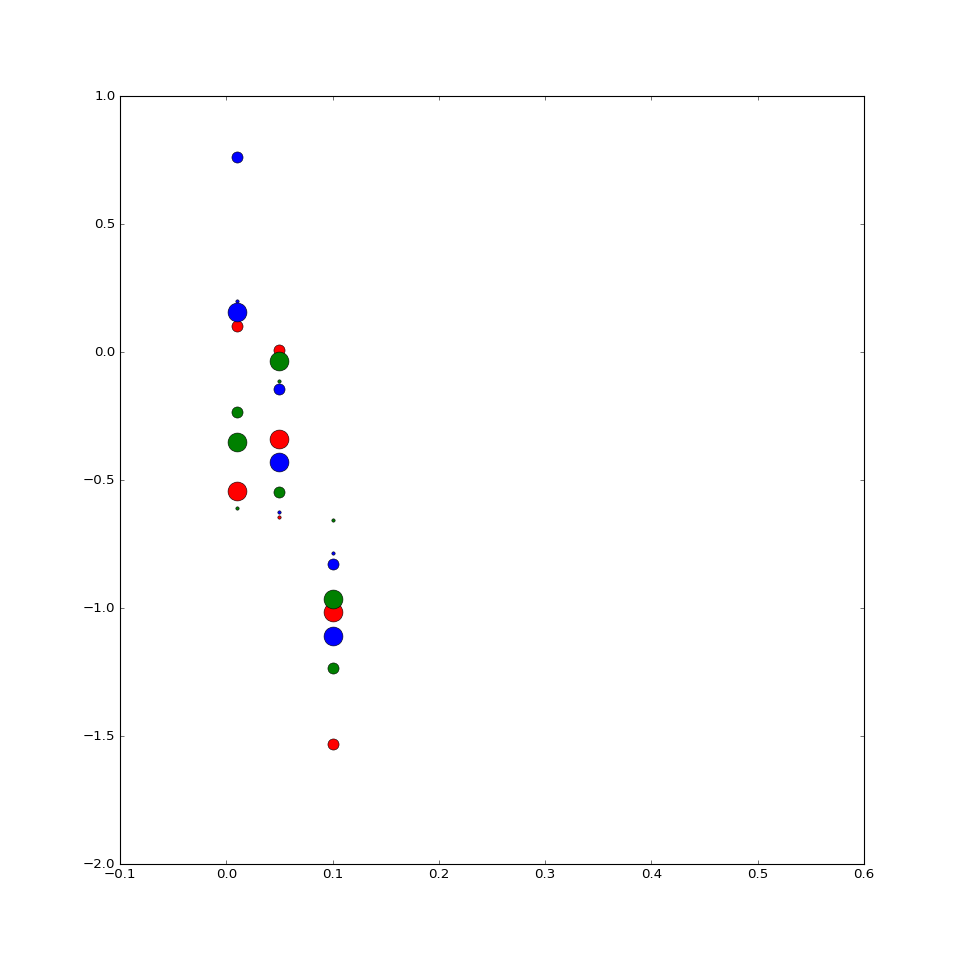

<IPython.core.display.Javascript object>


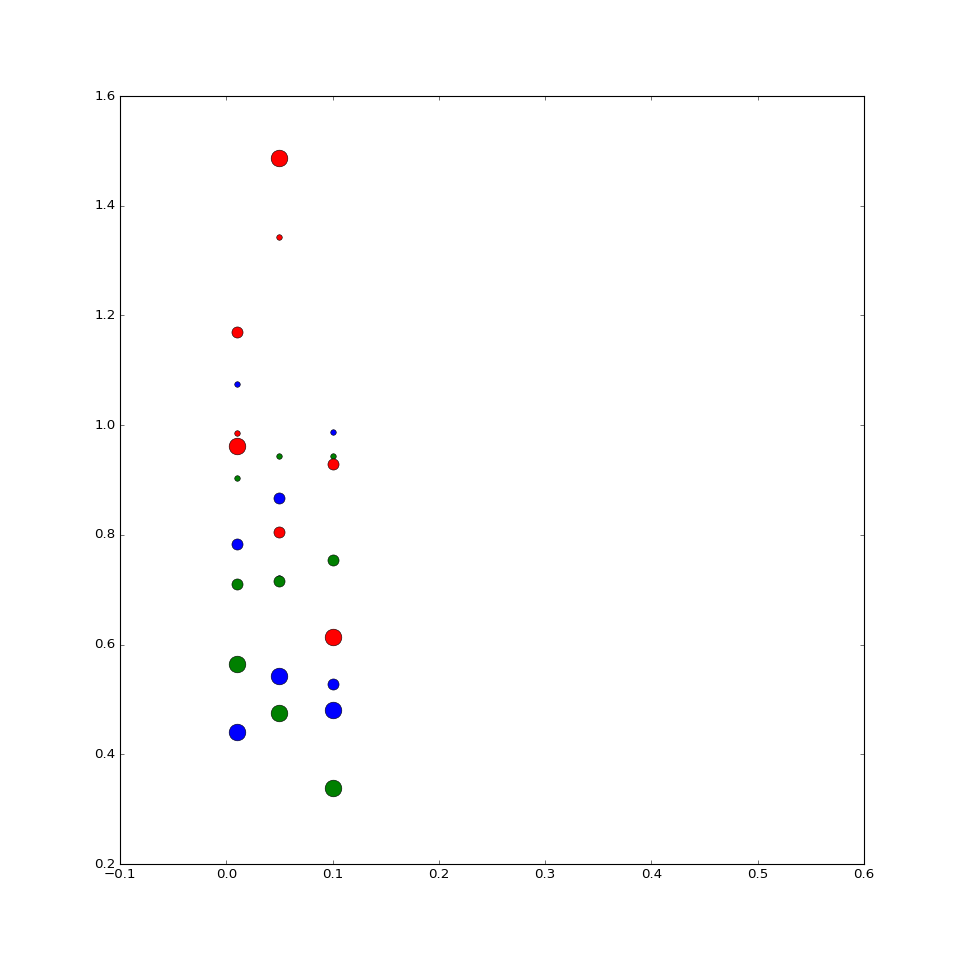

In [72]:
means=[]
stds=[]

for sig in [50,150,300]:
    for MC in [1000,5000,10000]:
        for rad in [0.01,0.05, 0.10]: #,0.20,0.50]:
            
            print 'number of signal points: %s \t number of MC point: %s \tradius: %s' % (sig,MC,rad)
            pulls,org_vals,fit_vals,fit_uncerts,iteration = calc_pull(10, sig, MC, rad)
            #plt.figure()
            #plt.hist(pulls, bins=50)
            #x = np.linspace(-5,5,1000)
            #y=normal(x,0,1)
            #plt.plot(x,(iteration*7/(50))*y,'y-',linewidth=2)
            parameters_mean = {'signal': sig, 'MC_points': MC, 'radius': rad, 'mean pulls': np.mean(pulls)}
            means.append(parameters_mean)
            parameters_std = {'signal': sig, 'MC_points': MC, 'radius': rad, 'mean stds': np.std(pulls)}
            stds.append(parameters_std)
            

plt.figure(figsize=(12,12))
point_color='bo'
sizes=0

for item in means:
    if (item['signal']==50):
        sizes=3
        if (item['MC_points']==1000):
            point_color='ro'
        if (item['MC_points']==5000):
            point_color='bo'
        if (item['MC_points']==10000):
            point_color='go'
    if (item['signal']==150):
        sizes=10
        if (item['MC_points']==1000):
            point_color='ro'
        if (item['MC_points']==5000):
            point_color='bo'
        if (item['MC_points']==10000):
            point_color='go'
    if (item['signal']==300):
        sizes=17
        if (item['MC_points']==1000):
            point_color='ro'
        if (item['MC_points']==5000):
            point_color='bo'
        if (item['MC_points']==10000):
            point_color='go'
    plt.plot(item['radius'],item['mean pulls'], point_color, markersize=sizes)#, label=('signal points %s \t num of MC points %s \t'% (item['signal'], item['MC_points']) ))
    plt.xlim(-.1,0.6)
    


plt.legend()
plt.figure(figsize=(12,12))
point_color='bo'

for item in stds:
    if (item['signal']==50):
        sizes=5
        if (item['MC_points']==1000):
            point_color='ro'
        if (item['MC_points']==5000):
            point_color='bo'
        if (item['MC_points']==10000):
            point_color='go'
    if (item['signal']==150):
        sizes=10
        if (item['MC_points']==1000):
            point_color='ro'
        if (item['MC_points']==5000):
            point_color='bo'
        if (item['MC_points']==10000):
            point_color='go'
    if (item['signal']==300):
        sizes=15
        if (item['MC_points']==1000):
            point_color='ro'
        if (item['MC_points']==5000):
            point_color='bo'
        if (item['MC_points']==10000):
            point_color='go'
    plt.plot(item['radius'],item['mean stds'], point_color, markersize=sizes)#, label=('signal points %s \t num of MC points %s \t'% (item['signal'], item['MC_points']) ))
    plt.xlim(-.1,0.6)

plt.legend()

#WITH STATIC NUM OF SIGNAL DATA

number of signal points: 300 	 number of MC point: 1000 	radius: 0.01
number of signal points: 300 	 number of MC point: 1000 	radius: 0.05
number of signal points: 300 	 number of MC point: 1000 	radius: 0.1
number of signal points: 300 	 number of MC point: 5000 	radius: 0.01
number of signal points: 300 	 number of MC point: 5000 	radius: 0.05
number of signal points: 300 	 number of MC point: 5000 	radius: 0.1
number of signal points: 300 	 number of MC point: 10000 	radius: 0.01
number of signal points: 300 	 number of MC point: 10000 	radius: 0.05
number of signal points: 300 	 number of MC point: 10000 	radius: 0.1


<IPython.core.display.Javascript object>


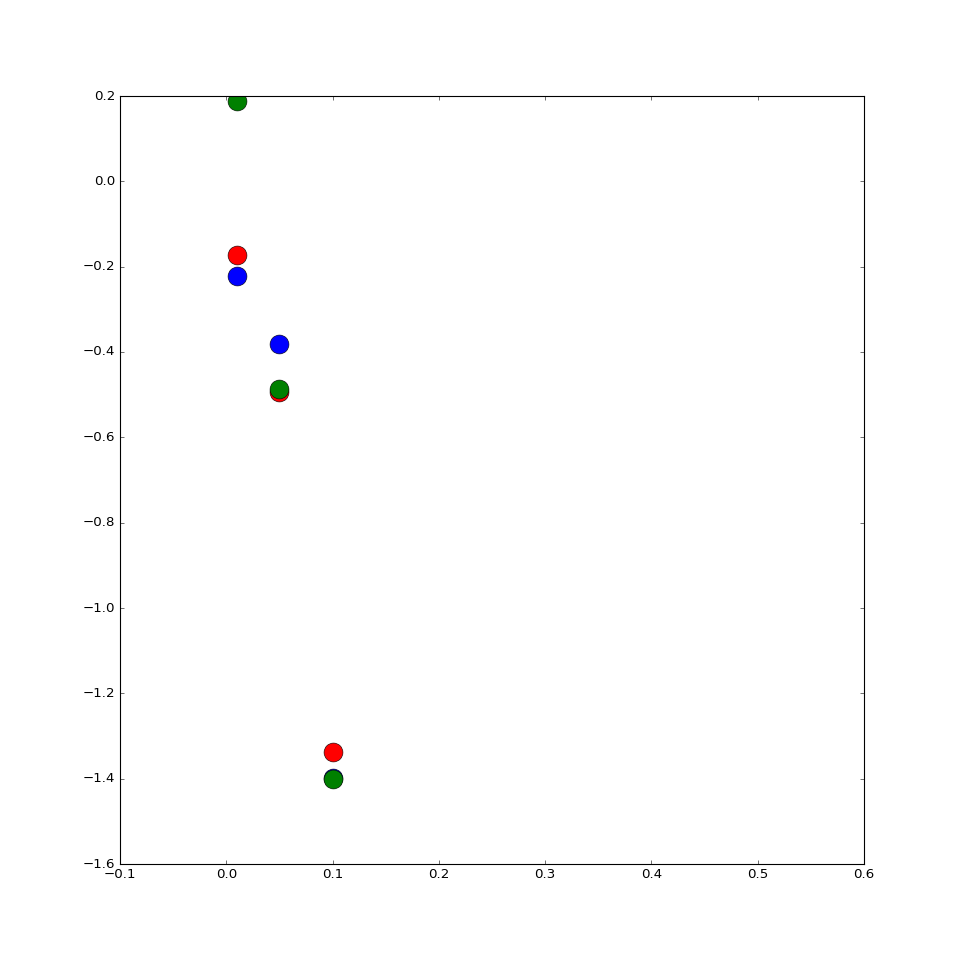

<IPython.core.display.Javascript object>


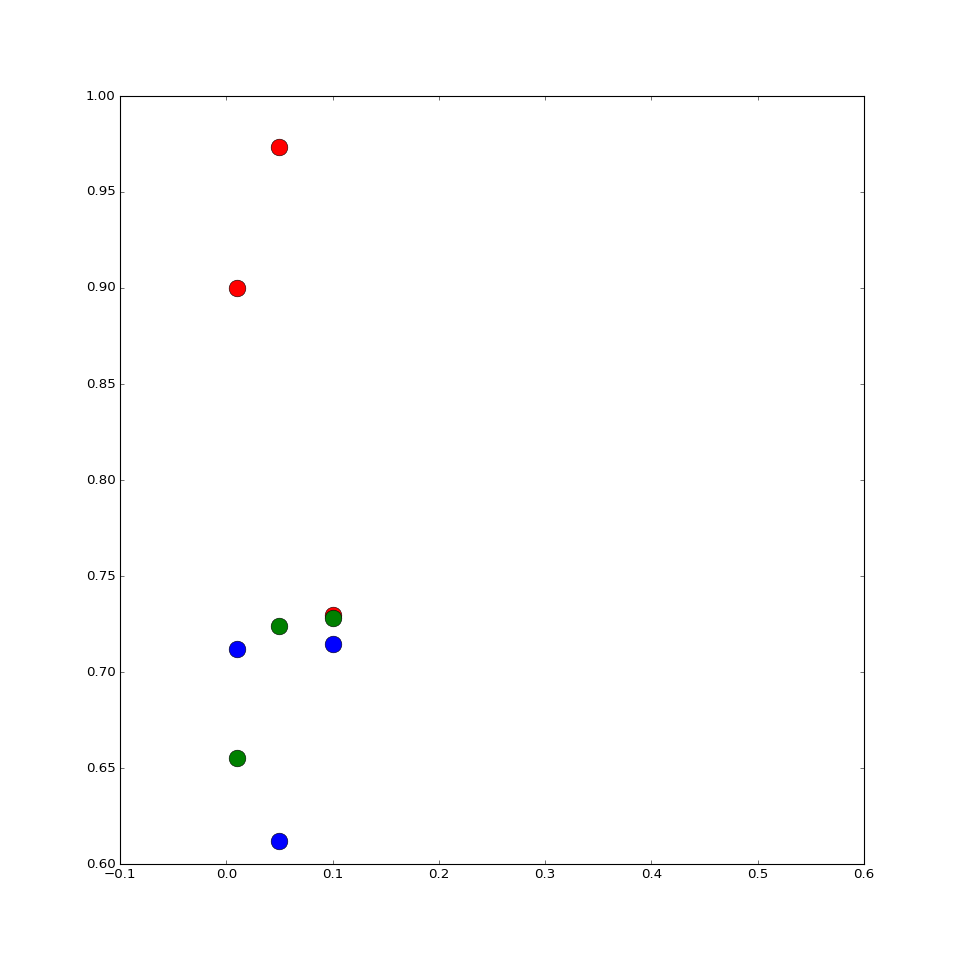

In [75]:
means=[]
stds=[]

for sig in [300]: #50,150,300]:
    for MC in [1000,5000,10000]:
        for rad in [0.01,0.05, 0.10]: #,0.20,0.50]:
            
            print 'number of signal points: %s \t number of MC point: %s \tradius: %s' % (sig,MC,rad)
            pulls,org_vals,fit_vals,fit_uncerts,iteration = calc_pull(50, sig, MC, rad)
            #plt.figure()
            #plt.hist(pulls, bins=50)
            #x = np.linspace(-5,5,1000)
            #y=normal(x,0,1)
            #plt.plot(x,(iteration*7/(50))*y,'y-',linewidth=2)
            parameters_mean = {'signal': sig, 'MC_points': MC, 'radius': rad, 'mean pulls': np.mean(pulls)}
            means.append(parameters_mean)
            parameters_std = {'signal': sig, 'MC_points': MC, 'radius': rad, 'mean stds': np.std(pulls)}
            stds.append(parameters_std)
            

plt.figure(figsize=(12,12))
point_color='bo'
sizes=0

for item in means:
    if (item['signal']==50):
        sizes=3
        if (item['MC_points']==1000):
            point_color='ro'
        if (item['MC_points']==5000):
            point_color='bo'
        if (item['MC_points']==10000):
            point_color='go'
    if (item['signal']==150):
        sizes=10
        if (item['MC_points']==1000):
            point_color='ro'
        if (item['MC_points']==5000):
            point_color='bo'
        if (item['MC_points']==10000):
            point_color='go'
    if (item['signal']==300):
        sizes=17
        if (item['MC_points']==1000):
            point_color='ro'
        if (item['MC_points']==5000):
            point_color='bo'
        if (item['MC_points']==10000):
            point_color='go'
    plt.plot(item['radius'],item['mean pulls'], point_color, markersize=sizes)#, label=('signal points %s \t num of MC points %s \t'% (item['signal'], item['MC_points']) ))
    plt.xlim(-.1,0.6)
    


plt.legend()
plt.figure(figsize=(12,12))
point_color='bo'

for item in stds:
    if (item['signal']==50):
        sizes=5
        if (item['MC_points']==1000):
            point_color='ro'
        if (item['MC_points']==5000):
            point_color='bo'
        if (item['MC_points']==10000):
            point_color='go'
    if (item['signal']==150):
        sizes=10
        if (item['MC_points']==1000):
            point_color='ro'
        if (item['MC_points']==5000):
            point_color='bo'
        if (item['MC_points']==10000):
            point_color='go'
    if (item['signal']==300):
        sizes=15
        if (item['MC_points']==1000):
            point_color='ro'
        if (item['MC_points']==5000):
            point_color='bo'
        if (item['MC_points']==10000):
            point_color='go'
    plt.plot(item['radius'],item['mean stds'], point_color, markersize=sizes)#, label=('signal points %s \t num of MC points %s \t'% (item['signal'], item['MC_points']) ))
    plt.xlim(-.1,0.6)

plt.legend()



#WITH THE POISSON and 50 iterations

number of signal points: 50 	 number of MC point: 1000 	radius: 0.01
number of signal points: 50 	 number of MC point: 1000 	radius: 0.05
number of signal points: 50 	 number of MC point: 5000 	radius: 0.01
number of signal points: 50 	 number of MC point: 5000 	radius: 0.05
number of signal points: 50 	 number of MC point: 10000 	radius: 0.01
number of signal points: 50 	 number of MC point: 10000 	radius: 0.05
number of signal points: 150 	 number of MC point: 1000 	radius: 0.01
number of signal points: 150 	 number of MC point: 1000 	radius: 0.05
number of signal points: 150 	 number of MC point: 5000 	radius: 0.01
number of signal points: 150 	 number of MC point: 5000 	radius: 0.05
number of signal points: 150 	 number of MC point: 10000 	radius: 0.01
number of signal points: 150 	 number of MC point: 10000 	radius: 0.05
number of signal points: 300 	 number of MC point: 1000 	radius: 0.01
number of signal points: 300 	 number of MC point: 1000 	radius: 0.05
number of signal point

<IPython.core.display.Javascript object>


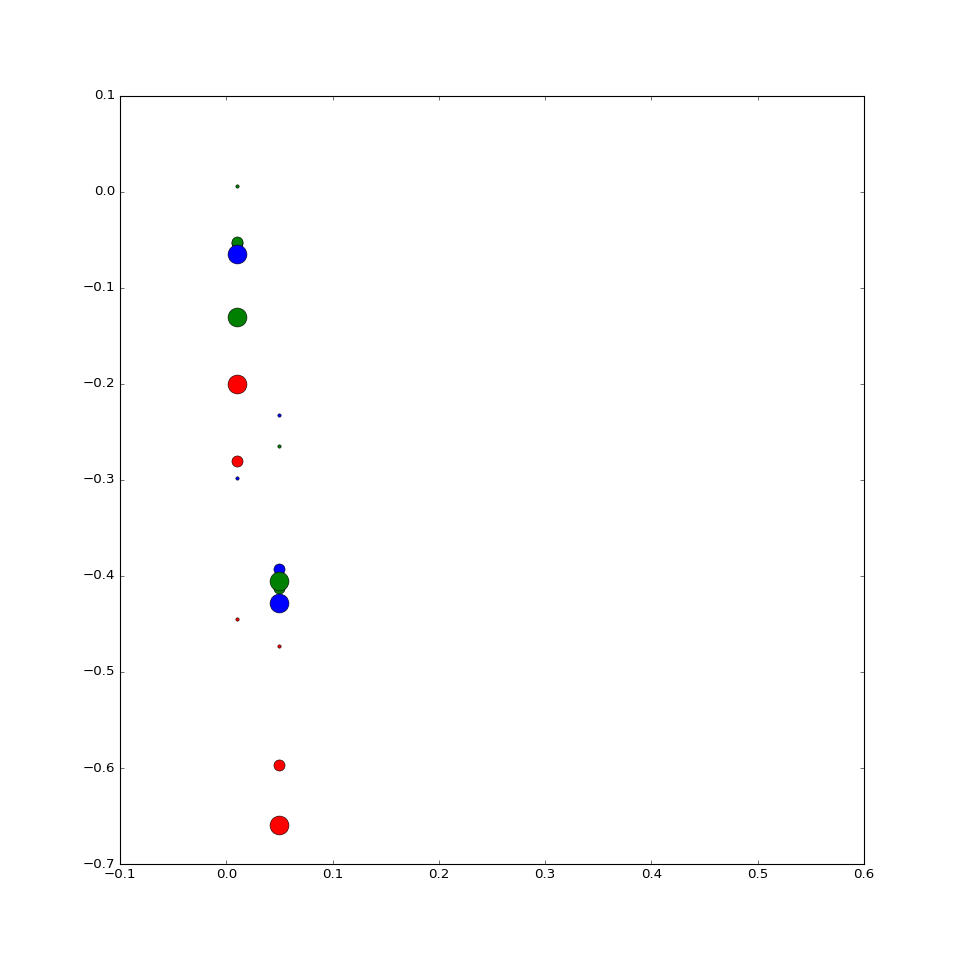

<IPython.core.display.Javascript object>


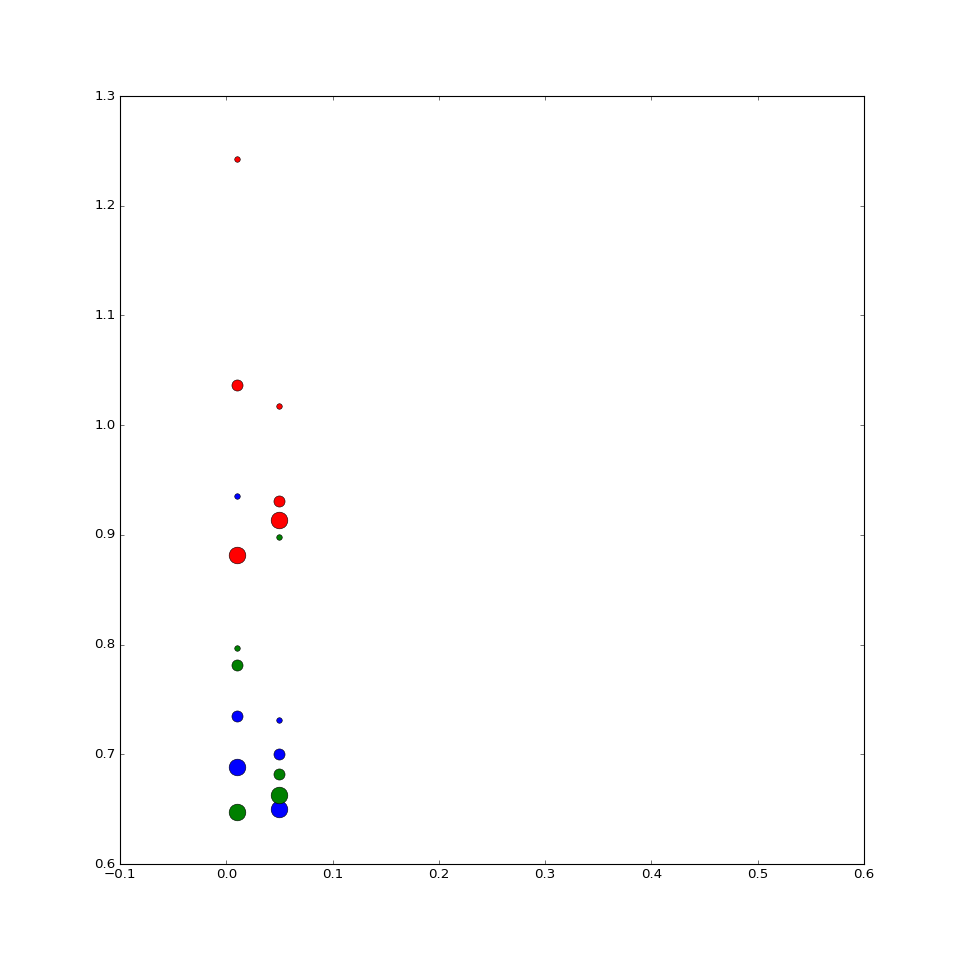

In [76]:
means=[]
stds=[]

for sig in [50,150,300]:
    for MC in [1000,5000,10000]:
        for rad in [0.01,0.05]: #, 0.10,0.20,0.50]:
            
            print 'number of signal points: %s \t number of MC point: %s \tradius: %s' % (sig,MC,rad)
            pulls,org_vals,fit_vals,fit_uncerts,iteration = calc_pull(100, sig, MC, rad)
            #plt.figure()
            #plt.hist(pulls, bins=50)
            #x = np.linspace(-5,5,1000)
            #y=normal(x,0,1)
            #plt.plot(x,(iteration*7/(50))*y,'y-',linewidth=2)
            parameters_mean = {'signal': sig, 'MC_points': MC, 'radius': rad, 'mean pulls': np.mean(pulls)}
            means.append(parameters_mean)
            parameters_std = {'signal': sig, 'MC_points': MC, 'radius': rad, 'mean stds': np.std(pulls)}
            stds.append(parameters_std)
            

plt.figure(figsize=(12,12))
point_color='bo'
sizes=0

for item in means:
    if (item['signal']==50):
        sizes=3
        if (item['MC_points']==1000):
            point_color='ro'
        if (item['MC_points']==5000):
            point_color='bo'
        if (item['MC_points']==10000):
            point_color='go'
    if (item['signal']==150):
        sizes=10
        if (item['MC_points']==1000):
            point_color='ro'
        if (item['MC_points']==5000):
            point_color='bo'
        if (item['MC_points']==10000):
            point_color='go'
    if (item['signal']==300):
        sizes=17
        if (item['MC_points']==1000):
            point_color='ro'
        if (item['MC_points']==5000):
            point_color='bo'
        if (item['MC_points']==10000):
            point_color='go'
    plt.plot(item['radius'],item['mean pulls'], point_color, markersize=sizes)#, label=('signal points %s \t num of MC points %s \t'% (item['signal'], item['MC_points']) ))
    plt.xlim(-.1,0.6)
    


plt.legend()
plt.figure(figsize=(12,12))
point_color='bo'

for item in stds:
    if (item['signal']==50):
        sizes=5
        if (item['MC_points']==1000):
            point_color='ro'
        if (item['MC_points']==5000):
            point_color='bo'
        if (item['MC_points']==10000):
            point_color='go'
    if (item['signal']==150):
        sizes=10
        if (item['MC_points']==1000):
            point_color='ro'
        if (item['MC_points']==5000):
            point_color='bo'
        if (item['MC_points']==10000):
            point_color='go'
    if (item['signal']==300):
        sizes=15
        if (item['MC_points']==1000):
            point_color='ro'
        if (item['MC_points']==5000):
            point_color='bo'
        if (item['MC_points']==10000):
            point_color='go'
    plt.plot(item['radius'],item['mean stds'], point_color, markersize=sizes)#, label=('signal points %s \t num of MC points %s \t'% (item['signal'], item['MC_points']) ))
    plt.xlim(-.1,0.6)

plt.legend()



#WITH THE POISSON and 100 iterations